In [93]:
from cleaning_t import *

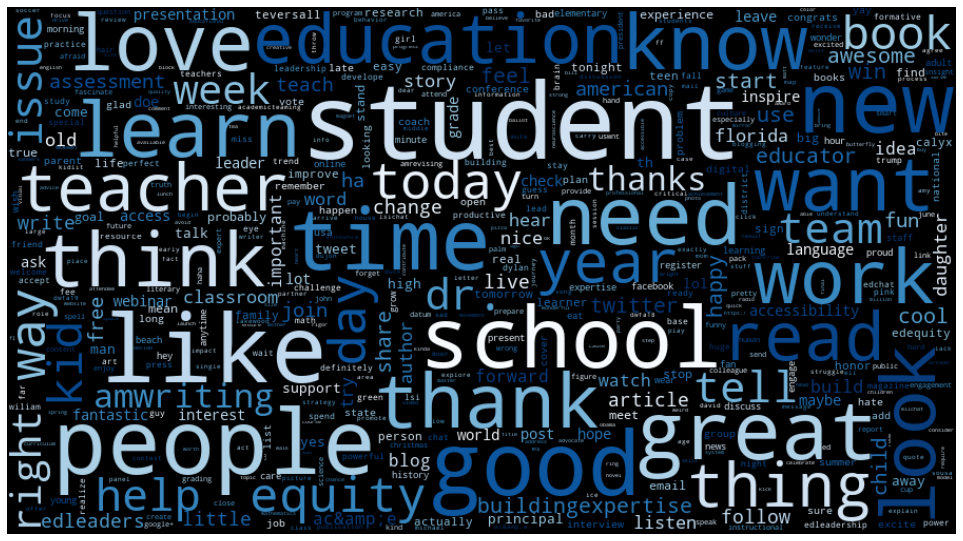

CPU times: user 430 ms, sys: 1.99 ms, total: 432 ms
Wall time: 433 ms
(1231, 732)


array([[0., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 0., 1., 1.],
       [1., 1., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 0.]])

In [83]:
def open_data(file):
    df = pd.read_csv(file)
    return df

tweets_user_friend = open_data('/Users/Noelia/Desktop/DATA_IRONHACK/FINAL_PROJECT/final_project_ironhack/output/User_csv/@maialee_tweets.csv')

tweets_user_friend['RT'] = tweets_user_friend.text.apply(retweet)

tweets_user_friend['mention'] = tweets_user_friend.text.str.findall(r'(?<![@\w])@(\w{1,25})').apply(', '.join)

tweets_user_friend['hashtag'] = tweets_user_friend.text.str.extract(r'(\#\w+)', expand=False)

tweets_user_friend['hashtag'] = tweets_user_friend['hashtag'].fillna("")

tweets_user_friend['date'] = tweets_user_friend['created_at']

tweets_user_friend['date'] = pd.DatetimeIndex(tweets_user_friend['created_at']).to_period('D')

tweets_user_friend = tweets_user_friend.drop(columns=["created_at"], axis=1)

nlp = spacy.load('en')

parser = English()

nlp.Defaults.stop_words |= {"rt","amp","xx", "xxx"}

tweets_user_friend['tokenized'] = tweets_user_friend['text'].apply(spacy_tokenizer)

num_features = 300
min_word_count = 50
num_workers = multiprocessing.cpu_count()
context_size = 10
downsampling = 1e-4
seed = 2

all_words = []
for line in tweets_user_friend['tokenized']: # try 'tokens'
    all_words.extend(line)
    
wordfreq = Counter(all_words)

wordcloud = WordCloud(width=900,
                      height=500,
                      max_words=500,
                      max_font_size=100,
                      relative_scaling=0.5,
                      colormap='Blues',
                      normalize_plurals=True).generate_from_frequencies(wordfreq)
plt.figure(figsize=(17,14))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

tfidf_vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, min_df=3)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(tweets_user_friend['text'].values)

print(tfidf_matrix.shape)

terms = tfidf_vectorizer.get_feature_names()

array_matrix = tfidf_matrix.toarray()

first_vector_tfidfvectorizer=tfidf_matrix[0]
df = pd.DataFrame(first_vector_tfidfvectorizer.T.todense(), index=tfidf_vectorizer.get_feature_names(), columns=["tfidf"])
df.sort_values(by=["tfidf"],ascending=False).head()

vocab = tfidf_vectorizer.vocabulary_

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)
dist

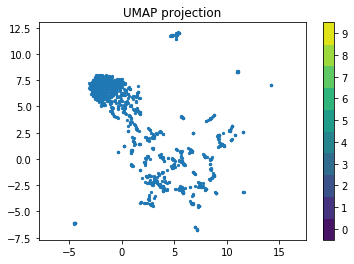

In [100]:
from mpl_toolkits.mplot3d import Axes3D
import umap

umap = UMAP(n_components=2, n_neighbors=8)
embedding = umap.fit_transform(dist)

#umap_df = pd.DataFrame(embedding, columns=[f'emb_{i+1}' for i in range(2)])

plt.scatter(umap_df['emb_1'], umap_df['emb_2'], cmap='Spectral', s=5)
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('UMAP projection', fontsize=12);


Silhouette Coefficient: 0.084


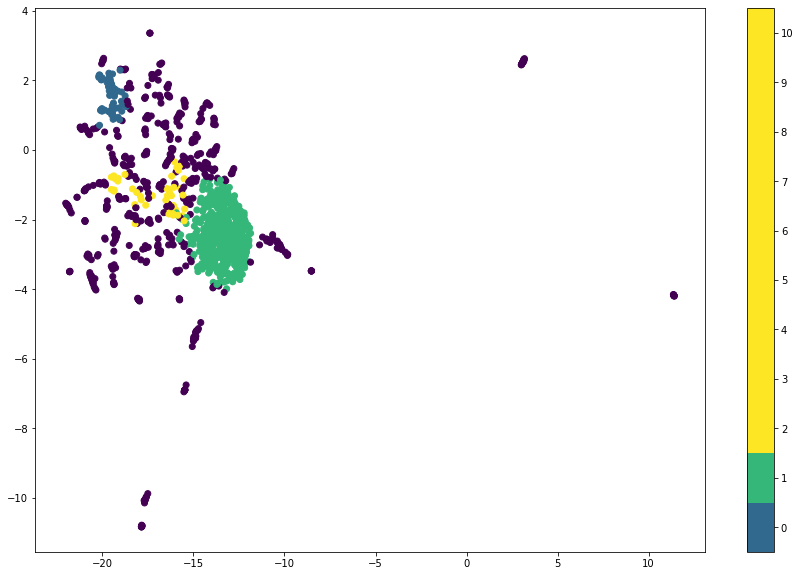

In [110]:
hdbscan = HDBSCAN(min_cluster_size=30, gen_min_span_tree=True, metric='braycurtis')

clustering = hdbscan.fit_predict(embedding)

np.unique(clustering)

hdbscan.labels_.max()

labels = hdbscan.labels_
labels

fig = plt.figure(figsize=(15, 10))
plt.scatter(embedding[:,0], embedding[:,1], c=clustering);
plt.colorbar(boundaries=np.arange(12)-0.5).set_ticks(np.arange(11))

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, hdbscan.fit_predict(embedding)))


CPU times: user 63.5 ms, sys: 1.57 ms, total: 65.1 ms
Wall time: 63.6 ms
Silhouette Coefficient: 0.449


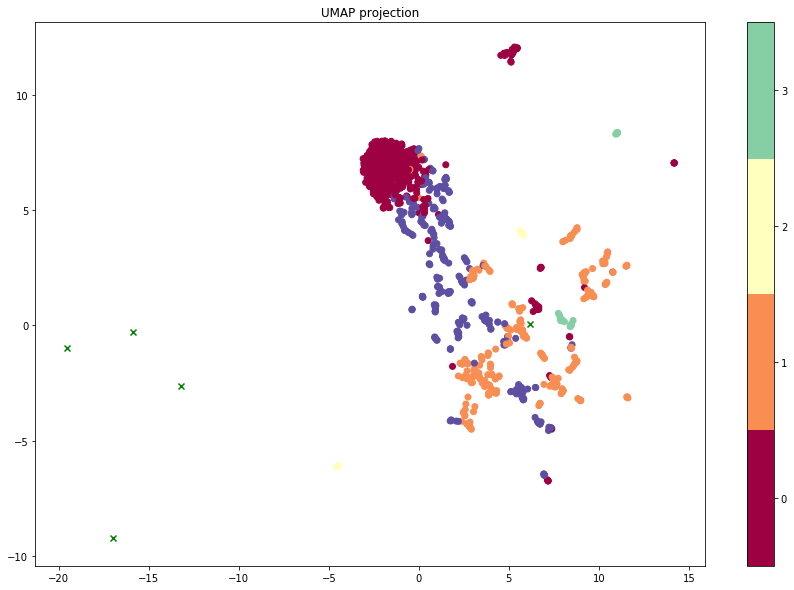

In [109]:
num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(embedding)

clusters = km.labels_.tolist()

fig = plt.figure(figsize=(15, 10))
plt.scatter(umap_df['emb_1'], umap_df['emb_2'], c =km.labels_, cmap='Spectral')
#plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(5)-0.5).set_ticks(np.arange(4))
centers = np.array(km.cluster_centers_)

#This array is one dimensional, thus we plot it using:
plt.scatter(centers[:,0], centers[:,1], marker="x", color='green')
plt.title('UMAP projection', fontsize=12);

print("Silhouette Coefficient: %0.3f"
      % silhouette_score(embedding, km.predict(embedding)))

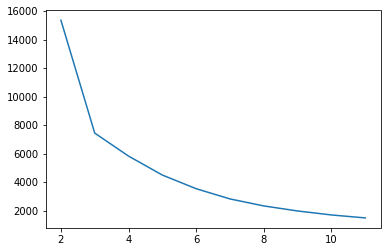

In [103]:
inertia = []

for n_clusters in range(2, 12):
    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(embedding)
    inertia.append(kmeans.inertia_)
    
plt.plot(range(2, 12), inertia);

In [88]:
tweets = {'tweet': tweets_user['text'].values,  'cluster': labels}
frame = pd.DataFrame(tweets, index = [labels] , columns = ['tweet', 'cluster'])

frame[frame['cluster']==1].head()

tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=terms)
tfidf_df.head()

def get_df_from_cluster(cluster):
    return tfidf_df[clustering==cluster]

top_words_cluster = get_df_from_cluster(0).T.sum(axis=1).sort_values(ascending=False)
top_words_cluster.head()

thank     20.064136
ha         6.694713
follow     2.204008
honor      1.818919
ww         1.488617
dtype: float64